## Momentum

Momentum-based Trading is based on the assumption that Stocks which have performed will in the past, will perform better in the coming future.

To define 'past', we take a variable **N**, and say that :

<centre> Momentum(For A particular stock) = Close Price(Today) - Close Price(N-day ago) </centre>

This gives us our first hyper-parameter (parameters of the model which could be changed in order to improve the model) : **N**

We would also be reshuffling our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp) at certain intervals of time, which gives us our second hyper-parameter: **T** (The time after which we'll be reshuffling our Portfolio)

Its never suggested to keep all your money invested, you must have some risk-free assets as well, so that even if you lose some of your cash in trading, you could still place better bets and regain that lost cash, Thus, We get our third Hyper-parameter: **R**, The Ratio of Total Balance, which we will using for investing.

You will not be investing in all the 30 Tickers now, Will you? You will choose the top few stocks, which show the highest promise in terms of Momentum, which brings us to another hyper-parameter: **M**, The Number of Top few stocks (based on Momentum), which you'll keep in your Portfolio.

Finally, There's some brokerage fee which you need to pay in order to place orders on the stock market, typically its less than 0.05% of the total amount : **F**


In [1]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Declaring the Hyperparameters
N = 50
T = 7
R = 0.8
M = 5
F = 0.0005   # 0.5% Brokerage fee

The Second step would be to define a function which reads the Prices of various Stocks into memory.

In the file DATA.csv , which we had uploaded in our repository, we have prices of 30 firms enlisted in S & P 500 Index (Apple, IBM, Cisco, Walmart and the like!) from 2nd January 2009 to 17th August 2020.

For our purposes, We'll only be requiring certain columns. On an honest note, Just getting the Columns on Ticker, Date and Adjusted Closing Price would do the job, but if you want, you may take Opening Price as well.

Read up about the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function from here, and figure out how you'll use it to do the job (You don't need all the columns!)

In [2]:
def GetData(NameOfFile):
  #START CODE HERE
  from google.colab import drive
  drive.mount('/content/drive')
  df = pd.read_csv(NameOfFile)
  df= pd.DataFrame(df)
  data = df.drop(['ind', 'high','low','volume','macd','rsi','cci','adx','turbulence'], axis=1)
  return data

In [3]:
####
data = GetData('/content/drive/MyDrive/SoC/DATA.csv')
data.tail()

Mounted at /content/drive


,datadate,tic,adjcp,open
87775,20200817,V,199.430,197.30
87776,20200817,VZ,58.780,58.73
87777,20200817,WBA,41.175,41.91
87778,20200817,WMT,135.600,134.35
87779,20200817,XOM,42.640,43.17


In [4]:
def PartitionData(data):
  DateToIndex={} # the Dictionary containing index : dates
  lists = [] # list of dataframes, each dataframe containing the data of adjcp, open of all 30 tickers at a particular date
  for i,j in zip(range(len(data.datadate.unique())),data.datadate.unique()) :  # getting all the dates
    DateToIndex.update({i: j})
  pd.DataFrame.from_dict(DateToIndex, orient='index', columns=['datadate'])

  for i in range(len(data.datadate.unique())):
    lists.append(data[data['datadate']==DateToIndex[i]].drop(['datadate'], axis=1))
  return lists, DateToIndex

# List containing the Data Partitioned according to Date, and

In [5]:
####
lists, DateToIndex = PartitionData(data)
len(lists),  DateToIndex[N+1]

(2926, 20090318)

Now, We need a function to calculate the Momentum value for all of our 30 Tickers.
To do this, We need to have a few things in mind:


1.   We need to start at Nth day in our list, as only then we'll be able to calculate the Momentum (This will be taken care of by later parts of the Program, when we actually run the Model)

2.   The Stock Market isn't open on all days, so we often won't be able to go N days behind, and will have to take the closest value instead(We can't just go N entries behind in the List we created and expect that to work, Why?) In order to work with dates, you should get to know more about the datetime library of Python from [here](https://thispointer.com/python-how-to-convert-datetime-object-to-string-using-datetime-strftime/) (Especially the datetime.strftime() function) and about the [datetime.timedelta()](https://www.studytonight.com/python-howtos/how-to-add-days-to-date-in-python) function.

Also, as you may have figured it out yourself, while DataFrames are great for Data Handling and small statistical calculations, They aren't so for big calculations as the Numpy Library has both a richer variety of functions for such manipulations and is also more efficient!

After we calculate the Momentum for all our Tickers, it would be a great thing to do, if we could divide their prices by their mean(in the N day interval, as we need to see which stock outperforms others and in order to do this, it won't be fair if we take the absolute growth in numbers!(Why?)



In [6]:
###
today = f'{datetime.datetime.now():%Y%m%d}'

# Getting the nearest date of today from the data
def NearestDate(today, data):
  data['date_difference'] = abs(data['datadate'] - int(today))
  df_sorted = data.sort_values('date_difference')
  today = str(df_sorted['datadate'].iloc[0])
  indexoftoday =0
  indexofNdaysAgo = 0
  for i in range(len(data.datadate.unique())):
   if DateToIndex[i]== int(today):
      indexoftoday = i
      indexofNdaysAgo = i-N
      break
  return today, indexoftoday, indexofNdaysAgo

today, indexoftoday, indexofNdaysAgo = NearestDate(today, data)
print(today, indexoftoday, indexofNdaysAgo)

20200817 2925 2875


In [7]:
def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today):
  # PartitionedDataFrameList : Pandas DataFrame, The Output of your last function
  # DateToIndex : Dictionary mapping dates to their index in the PartitionedDataFrameList
  # today : Today's date (string) In Format: YYYYMMDD

  # NdaysAgo is a datatime.date() object contining the required data, you need to convert it to a string and then check if its
  # Actually there in the Data you have or will you have to get going using some other nearest date

  NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N)
  indexoftoday =0
  indexofNdaysAgo = 0
  for i in range(len(data.datadate.unique())):
   if DateToIndex[i]== int(today):
      indexoftoday = i
      indexofNdaysAgo = i-N
      break

  r = np.array(PartitionedDataFrameList[indexoftoday]['adjcp'])
  s = np.array(PartitionedDataFrameList[indexofNdaysAgo]['adjcp'])

  newdf = pd.DataFrame()
  newdf['momentum'] = s-r

  mean = np.zeros([30,], dtype = float)
  for i in range(N):
     mean += np.array(PartitionedDataFrameList[indexofNdaysAgo+i-1]['adjcp'])
     mean /= N

  newdf['mean']=mean
  mbymN = np.array(newdf['momentum'] / newdf['mean'])
  return mbymN
# Numpy Array containing the Momentum divided by the mean(in the N-day period considered) of all the 30 tickers in the required order.

In [8]:
####
MomentumByMean = GetMomentumBasedPriority(lists, DateToIndex ,today)
MomentumByMean

array([-13.52450035,   5.94171076,   9.37119794,  -1.25366025,
         6.56731553,   5.47610596,  -1.11466922,  -1.70221939,
         3.49052474,  -5.80020146,   2.9855252 ,  15.54572111,
        -0.55940557,   5.5134839 ,   0.89126268,  -2.73144854,
         0.79781637,  -1.46667782,  -5.41868364,  -1.35735395,
        -3.02936719,  -6.19660586,   7.19680245,   3.47176171,
        -1.31974283,   0.04463499,  -0.87079007,   4.98763668,
        -5.21774201,  11.8879117 ])

Even after you have got your Momentum-based priorities, and have decided which stocks to buy and what will be the weight of each, you still need to figure out how much of each will you buy. To do this, first you'll sell all your pre-owned stocks which will increase your cash in hand, then you'll know the stocks to buy and their relative weights (given by their Momentum/mean) and you need a function which tells you how many stocks to buy for each ticker!

In [9]:
def GetBalanced(prices, weights,balance):
  # prices: Numpy array containing Prices of all the 30 Stocks
  # weights : Multi-hot Numpy Array : The Elements corresponding to stocks which are to be bought(Top M Stocks with positive Momentum Indicator) are set to their priority, All other elements are set to zero.
  # Returns Numpy array containing the number of shares to buy for each stock!
  x=0
  for i in range(1,M+1,1):
    x= x+ M-i+1
  z = balance/x
  buy = np.array(np.floor((z*weights)/ prices))
  print(buy)
  return buy

In [10]:
####
prices =  np.array(lists[-1]['open']).reshape((len(data.tic.unique()),1)) # Numpy array containing Prices of all the 30 Stocks
priority_values = np.array([1, 2, 3, 4, 5]).reshape((5,1))

top_stocks_indices = np.argsort(MomentumByMean)[-M:]
weights = np.zeros([len(data.tic.unique()),1], dtype=float)
weights[top_stocks_indices] = priority_values

ndf = pd.DataFrame()
ndf['tic']= data[:len(data.tic.unique())]['tic']
ndf['No. to buy']=GetBalanced(prices, weights, 10000)


[[ 0.]
 [ 0.]
 [11.]
 [ 0.]
 [15.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [67.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [20.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [61.]]


Now, We need something to simulate our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp). In order to do that we need a class, which has certain  basic features and functionalities.

Features :


1.   Your Initial Balance
2.   Your Current Balance
3.   A list(/any other container) storing the number of stocks of each ticker currently in possession. (Numpy Array prefered)
4.   Most recent prices of all the stocks (As a Numpy array)

Functionalities:



1.   Calculating current Net Worth (Balance+Total Evaluation of all Stocks owned!)
2.   Buying a Particular Stock (Keep the Transaction fee in mind!)
3.   Selling a particular Stock whole (Keep the Transaction Fee in mind!)
4.   Rebalance Portfolio  (Takes Numpy array as input)
5.   Function to change the value of most recent prices stored (Takes Numpy array as input)





In [21]:
class PortFolio:
  def __init__(self, ibalance, StockHoldings, Prices):
    self.ibalance = ibalance
    self.cbalance = ibalance
    self.StockHoldings = np.array(StockHoldings)
    self.Prices = Prices

  def CalculateNetWorth(self):
    #Return Net Worth (All Shares' costs+ Balance)

    stockworth = 0
    for i in range(len(self.StockHoldings)):
      stockworth += self.StockHoldings[i]*self.Prices[i]
    NetWorth = self.cbalance + stockworth
    return NetWorth

  def BuyStock(self, index, number):
    #index : The index of the Stock to buy (0-29)
    #number : Number of shares to buy (float)
    CostOfStock = self.Prices[index]*number
    CostOfStock += CostOfStock*F
    if number!=0 & int(self.cbalance)>=int(CostOfStock):
      self.cbalance -= CostOfStock
      self.StockHoldings[index] += number

  def SellStock(self,index):
    #index : The index of the Stock to sell (0-29)
    numberSelled = self.StockHoldings[index]
    total_earning = (self.Prices[index]*self.StockHoldings[index])
    total_earning -= total_earning*F
    self.cbalance += total_earning
    self.StockHoldings[index] = 0

  def ChangePricesTo(self, newPriceVector):
    # newPriceVector : Numpy array containing the prices of all the stocks for the current day
    self.Prices = np.array(newPriceVector)

  def RebalancePortFolio(self, newWeights):
    # newWeights : Numpy array containing Momentum/Mean for all stocks in the N-day period

    # First sell all your pre-owned Stock (make sure to take transaction fee into account!)
    # This would change your total balance
    for i in range(0,len(self.StockHoldings),1):
     self.SellStock(i)
    # Then take the top M(/might be less than M, if >(30-M) had negative Momentum) and send them to the GetBalanced() Function
    x=0
    for i in range(1,M+1,1):
       x= x+ M-i+1
    z = self.cbalance/x
    self.StockHoldings = list((np.floor(z*newWeights/ prices)))

    # Then take that output and pass them to the BuyStocks function!
    for i in range(len(self.StockHoldings)):
      self.BuyStock(i, self.StockHoldings[i])

With that the difficult part is over!

Now, all you need to work on is a main loop, which calls all these functions

In [23]:
prices =  np.array(lists[-1]['open']).reshape((len(data.tic.unique()),1))
myPortfolio = PortFolio(10000, 3*np.ones(30), prices)
NetWorthAfterEachTrade = [myPortfolio.CalculateNetWorth()]

Networth =[]
#Start processing from the (N+1)th Day(among the ones recorded in the Data)
for i in range(N+1,N+20):
  # Change the Prices to the ith Term
  # myPortfolio = PortFolio(10000, 3*np.ones(30), np.array(lists[i]['open']))
  myPortfolio.Prices = np.array(lists[i]['open'])

  # Get NetWorth and store in list
  Networth.append(myPortfolio.CalculateNetWorth())

  # Check if you need to rebalance Portfolio's Today

  # If so, do it by Calling first the GetMomentumBasedPriority function and then passing it to the rebalance function
  MomentumByMean = GetMomentumBasedPriority(lists, DateToIndex , str(DateToIndex[i]))
  top_stocks_indices = np.argsort(MomentumByMean)[-M:]
  newWeights = np.zeros([len(data.tic.unique()),1], dtype=float)
  newWeights[top_stocks_indices] = np.array([1, 2, 3, 4, 5]).reshape((5,1))
  myPortfolio.RebalancePortFolio(newWeights)



##Moment of Truth

Time to check, if your Program actually works!

Plot the data you collected in various ways and see if what you did worked!

Feel free to use whichever one of Matplotlib or Seaborn you want to.

You should try changing the hyper-parameters to increase(/decrease) your performance!


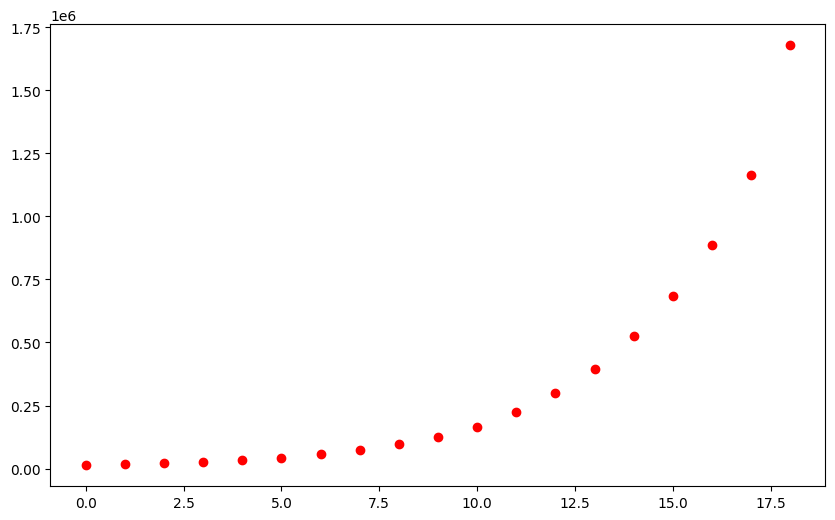

[1265.43300806]


In [26]:
def VizualizeData(array):
  plt.figure(figsize=(10,6))
  for i in range(len(array)):
    plt.scatter(i,array[i],color='r')
  plt.show()

## Visulaising net worth after predicting the no. of stocks to buy from N+1 to N+11
VizualizeData(Networth)


## **Conclusion**

*According to the data if we buy an sell the prices according to momentum strategy we will reach an infinity profit.`*

In [32]:
print(((Networth[1]-Networth[0])/Networth[0])*100)

[25.52764317]


*Percentage profit in the Net Worth in just 1 day is 25%*